# Load packages

In [133]:
import numpy as np
import pandas as pd
import os
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

# Load data

In [136]:
data = pd.read_csv("new_data_all.csv")
print(data.shape[0])
# remove NaN in emotion
data = data[data["emotion_probability"] < 1.0]
data = data[data["emotion_probability"] != 0.0]
print(data.shape[0])
# reset index
data = data.reset_index(drop = True)

9794
9585


In [137]:
data.sample()

,index,username,date,retweets,favorites,text,emotion,emotion_probability
3140,3527,realDonaldTrump,09.06.19 14:26,18973,87839,".....there is not, we can always go back to ou...",sadness,0.733822


## Data pre-processing

In [138]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "entityrecognizer"])
def preprocess(text):
    doc = nlp(text)
    result = []
    
    for token in doc: 
        if token.is_alpha == True: 
                result.append(token.lemma_)
    return result

In [139]:
# create list of all cleand texts
text_preprocessed = []
for i in range(data.shape[0]):
    text_preprocessed.append(' '.join(word for word in preprocess(data.text[i])))
data["text"] = text_preprocessed

# Split the Data

In [140]:
X = data["text"]
y = data["emotion"]
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [141]:
# Encode respond variable
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# Data Preprocessing

- convert it to lowercase
- filter out punctuation marks such as ? and !
- remove any special characters such as @ and $
- convert the text into a preferred number representation

In [142]:
vocab_size = 1000
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"

## Tokenizer

In [143]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

### Word index

In [144]:
word_index = tokenizer.word_index

In [145]:
print("word index length: ", len(word_index))
word_index

word index length:  8832


{'<OOV>': 1,
 'the': 2,
 'be': 3,
 'to': 4,
 'and': 5,
 'a': 6,
 'of': 7,
 'in': 8,
 'have': 9,
 'for': 10,
 'that': 11,
 'do': 12,
 'on': 13,
 'will': 14,
 'i': 15,
 'great': 16,
 'our': 17,
 'with': 18,
 'it': 19,
 'we': 20,
 'they': 21,
 'this': 22,
 'you': 23,
 'much': 24,
 'not': 25,
 'at': 26,
 'all': 27,
 'he': 28,
 'very': 29,
 'people': 30,
 'by': 31,
 'get': 32,
 'country': 33,
 'president': 34,
 'so': 35,
 'no': 36,
 'my': 37,
 'make': 38,
 'now': 39,
 'just': 40,
 'big': 41,
 'democrats': 42,
 'who': 43,
 'go': 44,
 'but': 45,
 'trump': 46,
 'good': 47,
 'news': 48,
 'thank': 49,
 'their': 50,
 'year': 51,
 'from': 52,
 'fake': 53,
 'can': 54,
 'many': 55,
 'or': 56,
 'want': 57,
 'there': 58,
 'his': 59,
 'out': 60,
 'border': 61,
 'time': 62,
 'would': 63,
 'pron': 64,
 'about': 65,
 'work': 66,
 'new': 67,
 'other': 68,
 'republican': 69,
 'up': 70,
 'never': 71,
 'american': 72,
 'say': 73,
 'than': 74,
 'america': 75,
 'me': 76,
 'what': 77,
 'job': 78,
 'if': 79,
 'sh

## Create sequence

In [146]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

### Pad sequences

In [147]:
# train data
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, 
                               padding=padding_type,
                               truncating=trunction_type)

In [148]:
# test data
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

# Prepare GloVe Embeddings

## GloVe: Global Vectors for Word Representation

[Link](https://nlp.stanford.edu/projects/glove/) - GloVe

In [149]:
main_path = os.getcwd()
folder_path = os.getcwd() + "/glove.twitter.27B"
#os.chdir(folder_path)
os.chdir(main_path)

In [150]:
os.chdir("/Users/phillipholscher/OneDrive-Linköpings universitet/LiU/Statistics and Machine Learning/Autum19T2/Text Mining/Project/Codeing/Classification")

In [151]:
file = "glove.twitter.27B.100d.txt"

embeddings_index = {}
f = open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
#os.chdir(main_path)
print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


### creating embedding matrix

In [152]:
embeddings_index["dead"]

array([ 7.6787e-01,  3.4185e-01, -1.0504e+00, -2.7491e-01,  2.4491e-02,
       -2.0183e-02,  4.7125e-02,  5.9248e-01,  3.2602e-01,  5.0199e-01,
        1.9899e-01,  3.6383e-01, -3.8838e+00,  1.1069e-01,  3.9010e-01,
        3.1555e-01,  1.8532e-01, -3.0759e-01, -1.5191e-02,  5.9521e-01,
       -4.4462e-01, -3.8137e-01,  2.9986e-02, -5.4368e-01,  5.6116e-01,
       -7.5132e-01, -3.9263e-01, -4.8859e-01,  4.5821e-02,  6.5119e-01,
        2.3959e-01, -6.6819e-01, -4.8025e-01, -2.5394e-01, -6.5626e-01,
        6.4008e-01, -3.3079e-01, -1.2079e-01, -3.3420e-01,  6.1693e-02,
       -3.6514e-01, -6.9959e-02, -1.2946e-03, -2.7926e-01,  4.1396e-02,
        8.7246e-02,  6.9458e-01,  5.0658e-01,  3.7505e-01,  6.0170e-01,
       -6.0909e-01,  4.4699e-01,  1.3856e-01,  3.1374e-02, -3.8786e-01,
       -4.5736e-01, -4.4563e-01,  6.9303e-01,  7.7792e-02,  3.2640e-01,
       -5.0218e-01, -3.6706e-01,  6.2484e-01, -4.6577e-01, -4.6011e-02,
       -7.4737e-01, -3.1002e-01,  6.2053e-01,  7.0937e-01, -8.22

In [153]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Embedding Layer

- We set trainable to False because we are using pre-trained word embeddings
- We set the weights to be the embedding_matrix we created above
- len(word_index) + 1 is the size of the vocabulary. We add one because 0 is never use— it is reserved for padding
- input_length is the length the input sequences

In [154]:
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# Define the Model


In [155]:
embedding_dim = 16
input_length = 100
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    #Dropout(0.2),
    Dense(6, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [156]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          883300    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 100, 32)           14976     
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 42        
Total params: 904,788
Trainable params: 21,488
Non-trainable params: 883,300
_________________________________________________________________


In [157]:
num_epochs = 15
history = model.fit(X_train_padded, y_train_enc, epochs=num_epochs, validation_data=(X_test_padded, y_test_enc))

Train on 7668 samples, validate on 1917 samples
Epoch 1/15
7668/7668 [==============================] - 40s 5ms/step - loss: 1.3306 - accuracy: 0.4742 - val_loss: 1.1738 - val_accuracy: 0.4784
Epoch 2/15
7668/7668 [==============================] - 36s 5ms/step - loss: 1.1202 - accuracy: 0.5265 - val_loss: 1.0737 - val_accuracy: 0.5634
Epoch 3/15
7668/7668 [==============================] - 35s 5ms/step - loss: 1.0064 - accuracy: 0.6122 - val_loss: 0.9690 - val_accuracy: 0.6249
Epoch 4/15
7668/7668 [==============================] - 33s 4ms/step - loss: 0.9429 - accuracy: 0.6360 - val_loss: 0.9377 - val_accuracy: 0.6468
Epoch 5/15
7668/7668 [==============================] - 34s 4ms/step - loss: 0.9023 - accuracy: 0.6493 - val_loss: 0.9217 - val_accuracy: 0.6505
Epoch 6/15
7668/7668 [==============================] - 34s 4ms/step - loss: 0.8785 - accuracy: 0.6596 - val_loss: 0.9003 - val_accuracy: 0.6641
Epoch 7/15
7668/7668 [==============================] - 34s 4ms/step - loss: 0.848

## Visualize model’s accuracy

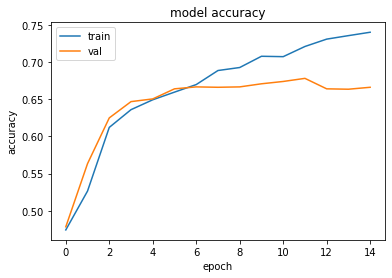

In [160]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Bi_LSTM_model_accuracy.png")
plt.show()

# Predictions

In [103]:
model.predict(X_test_padded)

array([[1.6594888e-01, 2.3264052e-01, 8.9318660e-04, 3.6790231e-03,
        5.9054732e-01, 6.2910304e-03],
       [6.9471106e-02, 1.2037157e-01, 2.3311870e-03, 1.6323628e-02,
        6.4087629e-01, 1.5062623e-01],
       [1.5312108e-02, 4.6866849e-02, 4.4510358e-05, 5.6576543e-02,
        2.3063582e-01, 6.5056419e-01],
       ...,
       [1.3510090e-01, 1.9532810e-01, 6.2333426e-04, 3.6024253e-03,
        6.5886188e-01, 6.4832834e-03],
       [5.2669857e-02, 1.2922566e-01, 7.6374788e-05, 1.8168679e-02,
        6.7650515e-01, 1.2335441e-01],
       [2.1876863e-01, 2.5199673e-01, 2.2310538e-03, 2.3656255e-03,
        5.2218097e-01, 2.4569659e-03]], dtype=float32)